# 1st July 2022 - Named Tuples

## `namedtuple`

When writing scripts of any kind you will often come across data collections, or groupings that could *really* do with being stored in some sort of structure. Now, you can always go away and make a class, with a constructor and properties and so on and so forth... but this is *scripting* and that might feel a bit too much like hard work. Instead I ask if you have heard of `namedtuple()`. 

`namedtuple()` is a factory that can be imported from the `collections` package in the Python standard library. It is available in IronPython, Python 2.7, an all the way up to 3.10 and beyond. It creates simple named tuple classes for you to use! But... what are they? Well, they're just tuples you can use. Except, these are "named", by which I mean they have a type name and property names. For example, see below.

In [1]:
from collections import namedtuple

# We are doing thee thrings here
# Naming the constructor of the tuple, in this case it is "CartesianPoint"
# Naming the type an instance of this tuple will have (here it is the same as the class name)
# Naming the properties the tuple will have as a list (here it is `x` and `y`)
CartesianPoint = namedtuple('CartesianPoint', ['x', 'y'])

new = CartesianPoint(0.5, -2.)

print(new)
print(new.x)
print(new.y)

CartesianPoint(x=0.5, y=-2.0)
0.5
-2.0


OK! Pretty straightforward. So let's play around with what we've got so far, maybe the type name is a bit long. Let's change the type to `CPoint`

In [2]:
CartesianPoint = namedtuple('CPoint', ['x', 'y'])

new = CartesianPoint(0.5, -2.)

print(new)

CPoint(x=0.5, y=-2.0)


Hang on, no, our alias for the constructor is too long. We need a shorter alias.

In [3]:
CartPoint = namedtuple('CartesianPoint', ['x', 'y'])

new = CartPoint(0.5, -2.)

print(new)

CartesianPoint(x=0.5, y=-2.0)


Woohoo! There we go. Alright... let's try changing one of these points!

In [4]:
new.x = -0.5

AttributeError: can't set attribute

Erk! That didn't work! What gives? Well we kinda forgot that this is a *tuple* and tuples are immutable. They can not be changed once created. This goes for additional properties as well!

In [ ]:
new.z = 0.0

## `typing.NamedTuple`

If you're working with modern Python then you already know about the *wonder* that is type hinting, and I can see some of you thinking "but how do you do typing??" and "dataclasses let me do type hinting though..." and as of Python 3.4 there is a nice way to do this.

In [5]:
from typing import NamedTuple

class CartesianPoint(NamedTuple):
    x: float
    y: float
        
        
cp = CartesianPoint(.5, .3)

print(cp)

cp.x = 5.

CartesianPoint(x=0.5, y=0.3)


AttributeError: can't set attribute

You can even set default values like you would in a dataclass.

In [6]:
from typing import NamedTuple

class CartesianPoint(NamedTuple):
    x: float
    y: float
    z: float = 0.
        
        
cp = CartesianPoint(.5, .3)

print(cp)

CartesianPoint(x=0.5, y=0.3, z=0.0)


## Downsides of `namedtuple`s


The `attrs` package has a nice section about named tuples and their weaknesses, which you should read [here](https://www.attrs.org/en/stable/why.html#namedtuples), and I summarise below with some of my own observations.

1. named tuples are subclasses of tuples and so can be indexed and iterated over (this is very unusual behaviour for a class)
2. You can unpack them by accident
3. All built-in tuple methods will be available on your instance regardless
4. You can't navigate to the class definition easily in IDEs
5. It is tricky to add documentation to your named tuple classes

However, despite this the docs contain the immortal words:

> "If you want a tuple with names, by all means: go for a namedtuple."

And the truth is that it is rare for there to be features in any language, which should never be used (except for [GOTO](https://xkcd.com/292/) obviously). Named tuples are a tool for scripting and should be treated as such. When scripting they can be really powerful.

![xkcd 292](./media/goto.png)
[source: xkcd 292](https://xkcd.com/292/)

## An Example!

Recently I needed to parse some mystery data, and the format was as follows.

```
ncols 500
nrows 500
xllcorner    386000
yllcorner    477000
cellsize     2
NODATA_value -9999
399.425 399.305 399.343 ... 397.59 398.332 398.87 399.395 399.43 
...
399.512 399.855 400.022 ... 400.442 400.872 401.765 402.457 403.157 
```

(I truncated the 500 x 500 grid of data such that it would fit in this box)

Now, it would be sensible to parse this grid of data using `numpy` to get a big 500 x 500 array. But what about the first 6 lines? That seems like it might be useful for interpreting the data. We need to create some variables, or a class, to store it. Additionally, this is data from one file, but in actuality I have 25. How do we keep them all together? We can use namedtuples!

> Below I have composed a short script that parses all 25 files and stores their data in instances of a namedtuple class called `ElevationFile`. The only packages I use that are not part of the Python Standard Library are [numpy](https://numpy.org/) and [matplotlib](https://matplotlib.org/), which are freely available and easy to install.


In [7]:
import pathlib
import numpy as np
from collections import namedtuple
import glob
import os


ElevationFile = namedtuple('ElevationFile', ['path', 'data', 'ncols', 'nrows', 'xllcorner', 'yllcorner', 'cellsize', 'null_value'])


def parse_header(file_path):
    with open(file_path, 'r') as f:
        header_data = []
        for i in range(6):
            line = f.readline()
            header_data.append(line.strip().split(' ')[-1])
    for i in range(4):
        header_data[i] = int(header_data[i])
    header_data[4] = float(header_data[4])
    header_data[5] = float(header_data[5])
    return header_data


files = {}
for path in glob.glob('./mapdata/*.asc'):
    data = np.genfromtxt(path, skip_header=6)
    header_data = parse_header(path)
    files[os.path.basename(path)] = ElevationFile(path, data, *header_data)




As you can see we've now got all the file data stored in a simple class instance that we can then use to perform whatever operations we want! A common one might be to mask all the null data across the datasets. It looks like all the files have the same null data value, but this isn't certain. It is moot, however, because we stored the null data value used for each file in the class!

In [8]:
MaskedData = namedtuple('MaskedData', ['data', 'name', 'elfile'])
masked_data = [MaskedData(np.ma.masked_where(elfile.data==elfile.null_value, elfile.data), key, elfile) 
               for key, elfile in files.items()]


And now we can plot our data and have a look at what it is.

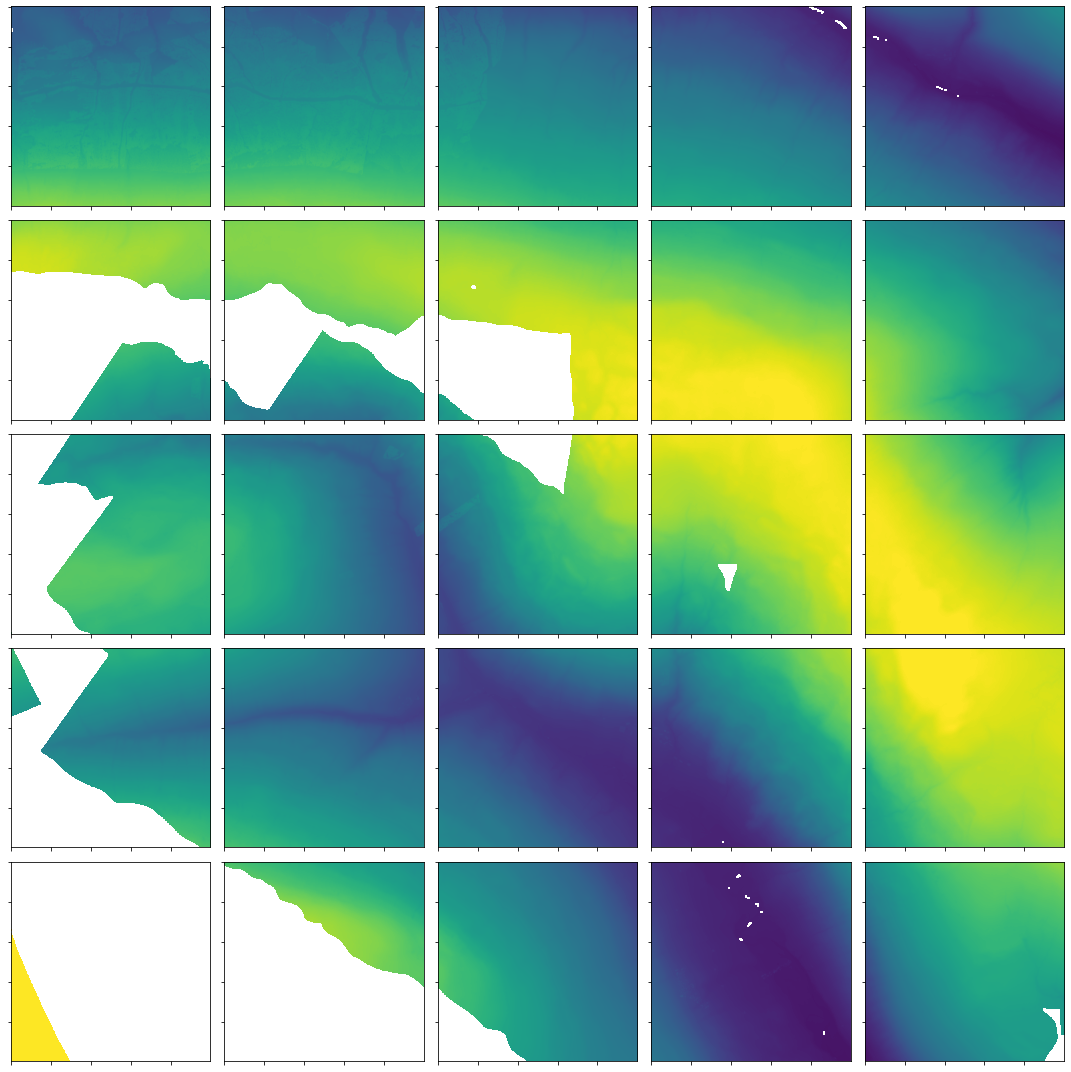

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
# We transpose the array of axes using axes.T and flip it to make sure everything is plotted in the correct order!
# This is just for orientation of the plots and does not affect the data.
for md, ax  in zip(masked_data, axes.T[:,::-1].flatten()):
    ax.imshow(md.data, vmin=250, vmax=600)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect(1)
    
plt.tight_layout()
plt.show()
    

It's elevation data! This data was taken from DEFRA UK data OGL v3.0 https://environment.data.gov.uk/DefraDataDownload/?Mode=survey . This is freely-available UK elevation data and if you google "Plover Hill" in Yorkshire and look at the elevation you'll see something a lot like this. Processing csv data like this is a common occurrence for engineers and data scientists and using named tuples can really help you keep your code concise and readable. It won't solve all your problems but it's a tool for the ring and worth knowing about.
